In [311]:
#Salim Amoukou                               #######################################################
                                             # La bataille des algorithmes d'optimisation en ligne #
#26/04/2019                                  #######################################################  

In [321]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import hinge_loss as hl
import matplotlib.pyplot as plt
import tqdm as tqdm
import seaborn as sns
import scipy as st
import random as rdm
import warnings; warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler 
#digits = load_digits()

"""-----------------------------------------------------UTILS--------------------------------------------------------------------"""
std = StandardScaler()
rdm.seed(5)
def pmin(u,li):
    for y in range(len(li)):
        if li[y]>u:
            li[y]=u
    return li

def pmax(u,li):
    for p in range(len(li)):
        if li[p]<u:
            li[p]=u
    return li


def hinge_loss(x,a,b,lam):
    seuil = a.dot(x)*b
    cost = (1 - a.dot(x)*b)*( a.dot(x)*b <1)
    return lam*cost+ (x.T.dot(x))/2

def gradient(x,a_t,b_t,lam):
    gradient = 0*(b_t*x.T.dot(a_t)>1) - b_t*a_t*(b_t*x.T.dot(a_t)<=1)
    return lam*gradient+x

def gradient_sca(x,a_t,b_t,lam):
    gradient = 0*(b_t*x*a_t>1) - b_t*a_t*(b_t*x*a_t<=1)
    return lam*gradient+x

def total_cost(x,a,b,lam):
    s = []
    for i in range(a.shape[0]):
        s.append(hinge_loss(x,a[i,:],b[i],lam))
    return np.mean(s)
import numpy as np


def euclidean_proj_simplex(v, s=1):
    """ Compute the Euclidean projection on a positive simplex
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the simplex
    Returns
    -------
    w: (n,) numpy array,
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / rho
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w


def euclidean_proj_l1ball(v, s=1):
    """ Compute the Euclidean projection on a L1-ball
    Solves the optimisation problem (using the algorithm from [1]):
        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project
    s: int, optional, default: 1,
       radius of the L1-ball
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s
    Notes
    -----
    Solves the problem by a reduction to the positive simplex case
    See also
    --------
    euclidean_proj_simplex
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # compute the vector of absolute values
    u = np.abs(v)
    # check if v is already a solution
    if u.sum() <= s:
        # L1-norm is <= s
        return v
    # v is not already a solution: optimum lies on the boundary (norm == s)
    # project *u* on the simplex
    w = euclidean_proj_simplex(u, s=s)
    # compute the solution to the original problem on v
    w *= np.sign(v)
    return w

def proj_w(x,w,z):
    v = np.abs(x*w)
    u = np.argsort(-v)
    sx = np.cumsum(np.abs(x)[u])
    sw = np.cumsum(1/w[u])
    rho = np.max( np.where(v[u]>(sx-z)/sw) )
    theta = (sx[rho] - z)/sw[rho]
    if (sum(np.abs(x))>z):
        x = np.sign(x)*pmax(0,np.abs(x)-theta/w)
    return x


def test(pred,y_test):
    acc = accuracy_score(pred,y_test)
    loss = hl(pred,y_test)
    plt.subplot(121)
    sns.countplot(pred)
    plt.subplot(122)
    sns.countplot(y_test)
    print('accuracy_score: {}'.format(acc))
    print('hinge_loss: {}'.format(loss))
    return acc,loss


def svm_fit(x_hat,X):
    return 1*(X.dot(x_hat)>0) - 1 *(X.dot(x_hat)<=0)

"""Smal_mnist"""
#X = digits.data
#y = digits.target
#Y = 1*(y == 3) -1 * (y != 3)
"""Big mnist"""
def load_data(digit=0,train_or_test='train'):
    X = pd.read_csv('mnist_{}.csv'.format(train_or_test))
    X = X.values
    Y = X[:,0]
    X = X[:,1:]
    #X = std.fit_transform(X)
    Y = 1*(Y== 0)-1*(Y!= 0)
    return X,Y



X_train,Y_train = load_data()
#X_train = std.fit_transform(X_train)
#X_test = std.fit(X_test)
X_test,Y_test= load_data(train_or_test='test')

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


In [2]:
def grad_descent(a,b,init,iters,cost,lam):
    """initialisation_des_paramètres"""
    d = a.shape[1]
    n = a.shape[0]
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    
    for t in tqdm.tqdm(range(0,iters)):
        hinge_grad = []
        x_t = param[t,:-1]
        
        for i in range(n):
            x = a[i,:]
            y = b[i]
            grad_i = 0*(y*x_t.T.dot(x)>1) - y*x*(y*x_t.T.dot(x)<=1) 
            hinge_grad.append(grad_i)
            
        grad_t = lam*sum(hinge_grad)/n + x_t
        n_t = 2/(t+1)
        param[t+1,:-1] = x_t - n_t*grad_t
        #calcul de l'erreur 
        e = 0
        for i in range(n):
            e += cost(param[t+1,:-1],a[i,:],b[i],lam)
        param[t+1,-1] = np.mean(e)
        
        #Rajouter la projection sur le simplexe
    return param




In [3]:
def sto_grad_descent(a,b,init,iters,cost,grad,lam):
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    #acc = []
    #print(a.shape)
    for i in tqdm.tqdm(range(0,iters)):
        eta = 2/(i+1)
        param[i+1,:-1] = param[i,:-1] - eta * grad(param[i,:-1],a[i,:],b[i],lam)
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        #pred = svm_fit(param[i+1,:-1],X_test)
        #acc.append(accuracy_score(pred,Y_test))
        
    return param

# Gradient_descent vs Stochastic_gradient_descent
Il est difficile d'avoir une comparaison pertinente entre la descente de gradient classique et la descente de gradient stochastique. La descente de gradient classique parcourt toute la base de données en une itération et effectue un pas de descente selon toute la base de donnée tandis que la descente de gradient stochastique fait son pas de descente à chaque nouvelle observation obeservée. Ainsi, la comparaison par nombre de gradient ou itération devient ambigüe.

On va quand meme essayer de comparer ces deux algorithmes en terme de nombre de gradient et d'itération.

- Avec le nombre de gradient : pour équilibrer, on va réduire la base de donnée afin d'avoir le meme nombre de gradient utilisés pour les deux. On va prendre un échantillon de taille 1000 : 10 itérations pour grad_descent (1000 gradients) et 10000 itérations pour sto_grad_descent (1000 gradient).

In [17]:

param_grad = grad_descent(X_train[:1000],Y_train[:1000],np.array(784*[0]),10,hinge_loss,1)
param_sto_grad = sto_grad_descent(X_train[:1000],Y_train[:1000],np.array(784*[0]),10000,hinge_loss,gradient,1)

100%|██████████| 10000/10000 [01:11<00:00, 139.70it/s]


In [18]:
sto_by_1000 = [param_sto_grad[i*1000,-1] for i in range(1,11)]

Text(0.5,1,'same gradient : small dataset')

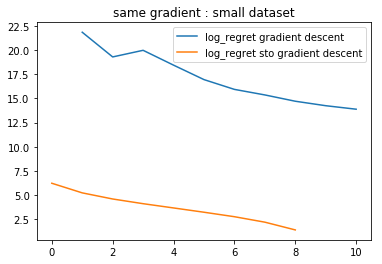

In [19]:
plt.plot(np.log(param_grad[:,-1]-min(param_grad[:,-1])),label='log_regret gradient descent')
plt.plot(np.log((sto_by_1000 - min(sto_by_1000))),label='log_regret sto gradient descent')
plt.legend()
plt.title('same gradient : small dataset')

Pour le même nombre de gradient, la descente de gradient stochastique est beaucoup plus rapide et performant que la descente de gradient classique. 

Conclusion : la descente de gradient classique requiert davantage de gradient pour performer.

- Par itération : Toujours sur la petite base de données

In [14]:
param_grad = grad_descent(X_train[:1000],Y_train[:1000],np.array(784*[0]),1000,hinge_loss,1)
param_sto_grad = sto_grad_descent(X_train[:1000],Y_train[:1000],np.array(784*[0]),1000,hinge_loss,gradient,1)

100%|██████████| 1000/1000 [00:00<00:00, 1165.09it/s]


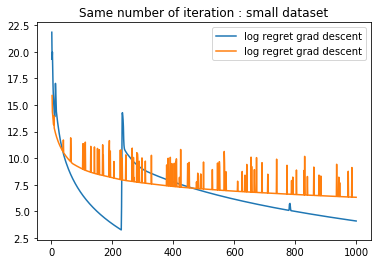

In [16]:
plt.plot(np.log(param_grad[:,-1]-min(param_grad[:,-1])),label='log regret grad descent')
plt.plot(np.log(param_sto_grad[:,-1] - min(param_sto_grad[:,-1])),label='log regret grad descent')
plt.title('Same number of iteration : small dataset')
plt.legend()
plt.show()
#accuracy...

Au début, la descente de gradient stochastique converge plus rapidement mais se laisse rapidement dépasser par la descente de gradient classique ce qui n'est pas étonnant car elle utilise davantage de gradient que cette dernière.

**Verifions cette conjecture sur toutes les données**

In [20]:
param_grad = grad_descent(X_train,Y_train,np.array(784*[0]),100,hinge_loss,1)
param_sto_grad= sto_grad_descent(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1)

100%|██████████| 1000/1000 [00:00<00:00, 1228.27it/s]


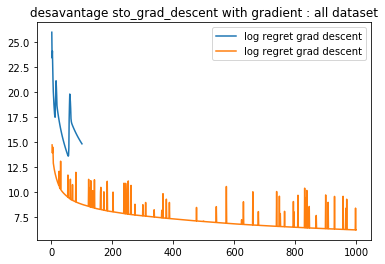

In [22]:
plt.plot(np.log(param_grad[:,-1]-min(param_grad[:,-1])),label='log regret grad descent')
plt.plot(np.log(param_sto_grad[:,-1] - min(param_sto_grad[:,-1])),label='log regret grad descent')
plt.title('desavantage sto_grad_descent with gradient : all dataset')
plt.legend()
plt.show()
#accuracy...

Lorsque la base de données est importante, la descente de gradient stochastique est plus efficace que la descente de gradient classique en terme d'itération. Il faut probablement plus de temps à la descente de gradient classique pour s'adapter à une plus large base de données.

Un bon tradeoff entre les deux est d'effectuer une descente de gradient stochastique par batch.

### A présent comparons les descentes de gradients stochastiques avec projection 

In [23]:
def sto_grad_descent_proj(a,b,init,iters,cost,grad,lam,s=1):
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    for i in tqdm.tqdm(range(0,iters)):
        eta = 2/(i+1)
        param[i+1,:-1] = euclidean_proj_l1ball(param[i,:-1] - eta * grad(param[i,:-1],a[i,:],b[i],lam),s)
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param

In [24]:
rdm.seed(1)
sto_grad = sto_grad_descent(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1)
rdm.seed(1)
sto_grad_s10 = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,10)
rdm.seed(1)
sto_grad_s1 = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,1)
rdm.seed(1)
sto_grad_s1000 = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,1000)
rdm.seed(1)
sto_grad_s100 = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,100)

100%|██████████| 1000/1000 [00:00<00:00, 1202.11it/s]


On va comparer ici les performances des différentes projections et aussi leur vitesse de convergence.
- Pour comparer les vitesses de convergence on observe la variance des paramètres à chaque itération deux à deux.

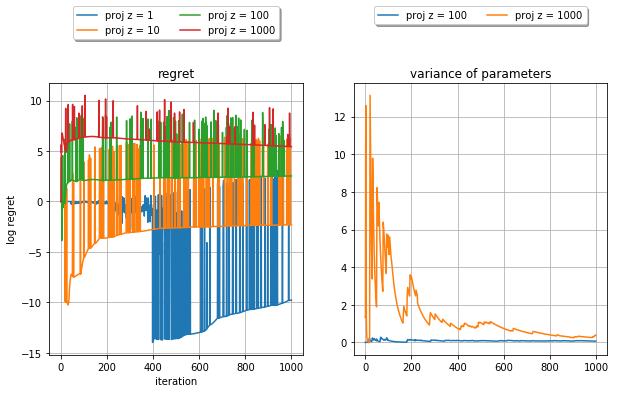

In [221]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(10, 5))  # 1 row, 2 columns

# First subplot
#ax[0].plot(sto_grad[:,-1])
ax[0].plot(np.log(sto_grad_s1[:,-1]),label='proj z = 1')
ax[0].plot(np.log(sto_grad_s10[:,-1]),label='proj z = 10')
ax[0].plot(np.log(sto_grad_s100[:,-1]),label='proj z = 100')
ax[0].plot(np.log(sto_grad_s1000[:,-1]),label='proj z = 1000')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("log regret")
ax[0].set_title("regret")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)
# Second item
#ax[1].plot([np.var([sto_grad[i,:-1],sto_grad[i+1,:-1]]) for i in range(999)])
#ax[1].plot([np.var([sto_grad_s1[i,:-1],sto_grad_s1[i+1,:-1]]) for i in range(999)],label='proj z = 1')
#ax[1].plot([np.var([sto_grad_s10[i,:-1],sto_grad_s10[i+1,:-1]]) for i in range(999)],label='proj z = 10')
ax[1].plot([np.var([sto_grad_s100[i,:-1],sto_grad_s100[i+1,:-1]]) for i in range(999)],label='proj z = 100')
ax[1].plot([np.var([sto_grad_s1000[i,:-1],sto_grad_s1000[i+1,:-1]]) for i in range(999)],label='proj z = 1000')
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)
ax[1].grid()
ax[1].set_title("variance of parameters");

Essayons d'avoir une meilleure visibilité sur les vitesses de convergence.

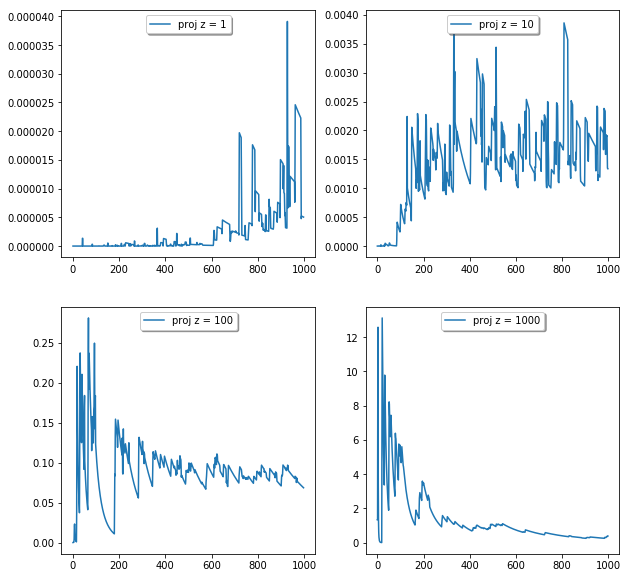

In [116]:
fig, ax = plt.subplots(2, 2, sharex='row', sharey=False, figsize=(10, 10))
#ax[1].plot([np.var([sto_grad[i,:-1],sto_grad[i+1,:-1]]) for i in range(999)])
ax[0,0].plot([np.var([sto_grad_s1[i,:-1],sto_grad_s1[i+1,:-1]]) for i in range(999)],label='proj z = 1')
ax[0,1].plot([np.var([sto_grad_s10[i,:-1],sto_grad_s10[i+1,:-1]]) for i in range(999)],label='proj z = 10')
ax[1,0].plot([np.var([sto_grad_s100[i,:-1],sto_grad_s100[i+1,:-1]]) for i in range(999)],label='proj z = 100')
ax[1,1].plot([np.var([sto_grad_s1000[i,:-1],sto_grad_s1000[i+1,:-1]]) for i in range(999)],label='proj z = 1000')
ax[0,0].legend(loc="upper center",  shadow=True)
ax[1,0].legend(loc="upper center",  shadow=True)
ax[0,1].legend(loc="upper center", shadow=True)
ax[1,1].legend(loc="upper center", shadow=True)


Comparons celle qui semblent converger c'est à dire la projection de la descente de gradient stochastique sur la boule **100** et **1000** avec la descente de gradient stochastique.

Text(0.5,1,'diff projB(100) vs sto_grad_normal')

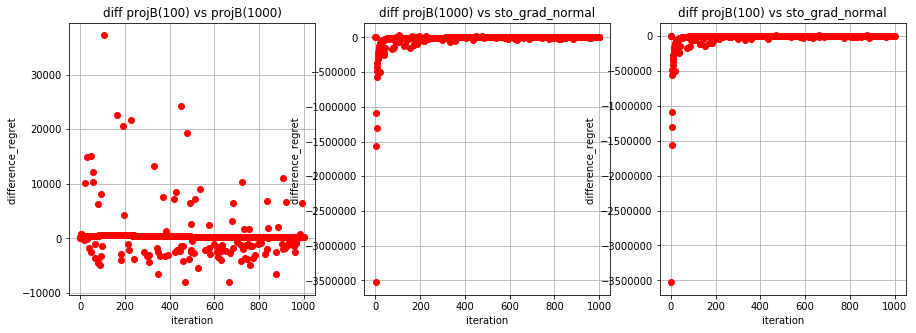

In [225]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(sto_grad_s1000[:,-1]-sto_grad_s100[:,-1],'ro')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("difference_regret ")
ax[0].set_title("diff projB(1000) vs projB(100)")
#ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[1].plot(sto_grad_s1000[:,-1]-sto_grad[:,-1],'ro')
ax[1].grid()
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("difference_regret ")
ax[1].set_title("diff projB(1000) vs sto_grad_normal")
#ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[2].plot(sto_grad_s100[:,-1]-sto_grad[:,-1],'ro')
ax[2].grid()
ax[2].set_xlabel("iteration")
ax[2].set_ylabel("difference_regret ")
ax[2].set_title("diff projB(100) vs sto_grad_normal")
#ax[2].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

Conclusion:

Par itération, on remarque au début une différence sur les erreurs de projection 100 et 1000 avec la descente de gradient stochastique. Puis, on peut observer une différence tout au long entre les deux projections.

Pour avoir une meilleure visibilité des performances, nous allons calculer le regret sur toute la base de données par itération pour les trois algorithmes.

In [123]:
#calculons le regret sur toute la base de données des deux meilleures avec sto : 
real_regret_proj1000  = [total_cost(sto_grad_s1000[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]
real_regret_sto = [total_cost(sto_grad[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]
real_regret_proj100 = [total_cost(sto_grad_s100[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

100%|██████████| 999/999 [12:59<00:00,  1.18it/s]


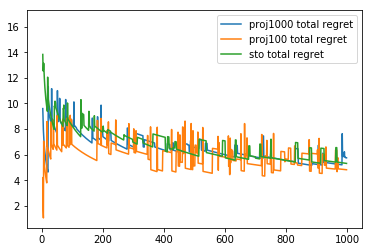

In [230]:
plt.plot(np.log(real_regret_proj1000-min(real_regret_proj1000)),label='proj1000 total regret')
plt.plot(np.log(real_regret_proj100-min(real_regret_proj100)),label='proj100 total regret')
plt.plot(np.log(real_regret_sto-min(real_regret_sto)),label='sto total regret')
plt.legend()

On remarque qu'elles semblent toutes augmenter leurs performances mais on peut voir que celle qui mène en général est la descente de gradient stochastique avec la projection 100.

Pour être clair, on peut affirmer cette hypothèse en traçant les cumilative loss.

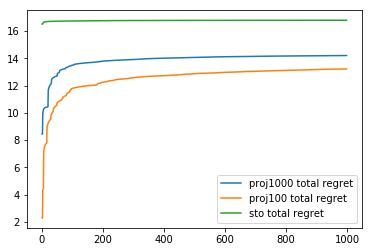

In [236]:
plt.plot(np.log(np.cumsum(real_regret_proj1000-min(real_regret_proj1000))),label='proj1000 total regret')
plt.plot(np.log(np.cumsum(real_regret_proj100-min(real_regret_proj100))),label='proj100 total regret')
plt.plot(np.log(np.cumsum(real_regret_sto-min(real_regret_sto))),label='sto total regret')
plt.legend()

## Stochastic gradient vs stochastic mirror descent

In [126]:

def sto_mirror_descent(a,b,init,iters,cost,grad,lam,s=1):
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    theta = init
    for i in tqdm.tqdm(range(0,iters)):
        eta = 2/(i+1)
        theta = theta - eta *(gradient(theta,a[i,:],b[i],lam)+theta)
        param[i+1,:-1] = euclidean_proj_l1ball(theta,s)
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param

In [237]:
rdm.seed(1)
param_sto = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,3000)
rdm.seed(1)
param_mirror = sto_mirror_descent(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,1000)


100%|██████████| 1000/1000 [00:00<00:00, 2873.00it/s]


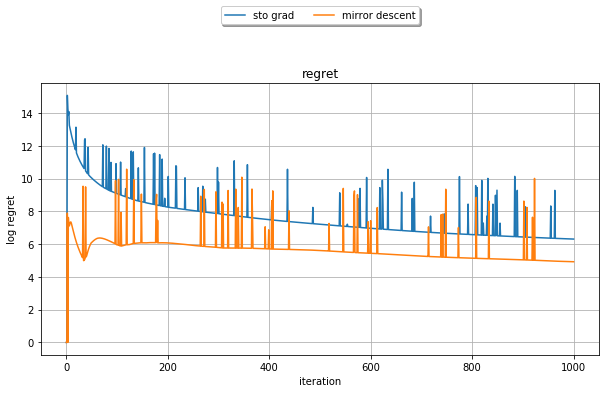

In [238]:
#Regret et vitesse de convergence
fig, ax = plt.subplots(figsize=(10, 5))  # 1 row, 2 columns

# First subplot
#ax[0].plot(sto_grad[:,-1])
ax.plot(np.log(sto_grad[:,-1]),label='sto grad')
ax.plot(np.log(param_mirror[:,-1]),label='mirror descent')

ax.grid()
ax.set_xlabel("iteration")
ax.set_ylabel("log regret")
ax.set_title("regret")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)
# Second item


- Observons la variance des paramètres des algos

Text(0.5,1,'sto_mirror parameters variance')

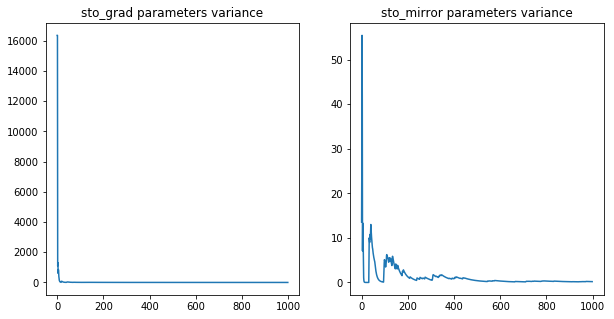

In [246]:
fig, ax = plt.subplots(1, 2, sharex='row', sharey=False, figsize=(10, 5))
#ax[1].plot([np.var([sto_grad[i,:-1],sto_grad[i+1,:-1]]) for i in range(999)])
ax[0].plot([np.var([sto_grad[i,:-1],sto_grad[i+1,:-1]]) for i in range(999)],label='proj z = 1')
ax[1].plot([np.var([param_mirror[i,:-1],param_mirror[i+1,:-1]]) for i in range(999)],label='proj z = 10')
ax[0].set_title('sto_grad parameters variance')
ax[1].set_title('sto_mirror parameters variance')

In [133]:
real_regret_mirror = [total_cost(param_mirror[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

100%|██████████| 999/999 [13:35<00:00,  1.27it/s]


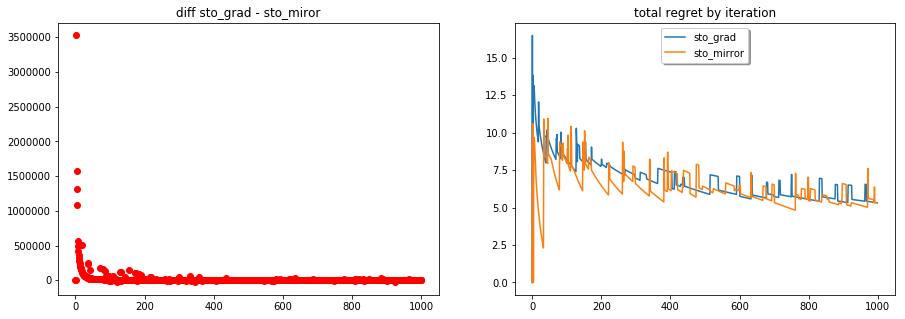

In [249]:
fig, ax = plt.subplots(1, 2, sharex='row', sharey=False, figsize=(15, 5))
#ax[1].plot([np.var([sto_grad[i,:-1],sto_grad[i+1,:-1]]) for i in range(999)])
ax[0].plot(sto_grad[:,-1] - param_mirror[:,-1],'ro')
ax[0].set_title('diff sto_grad - sto_miror')
ax[1].plot(np.log(real_regret_sto),label='sto_grad')
ax[1].plot(np.log(real_regret_mirror),label='sto_mirror')

ax[1].set_title('total regret by iteration')

#ax[0].legend(loc="upper center", shadow=True)
ax[1].legend(loc="upper center", shadow=True)

On voit que les deux algos sont très proche bien que la stochastic mirror descent a l'air de se demarquer de l'autre.

## stochastic_exponential_grad_pm vs randomized_exponential_grad vs stochastic gradient descent

In [137]:

def sto_exp_grad_mp(a,b,iters,cost,grad,lam,s):  
    d = a.shape[1]
    r = np.ones(d)
    r_2 = np.ones(d)
    param = np.zeros((iters + 1,d+1))
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    w = np.array((2*d)*[1/(2*d)])
    param[0,:-1] = s*(w[:d]-w[d:])
    param[0,-1] = cost(param[0,:-1],a[0,:],b[0],lam)
    
    eta = s*np.sqrt(np.log(d)/iters)
    
    for i in tqdm.tqdm(range(0,iters)):
        x = param[i,:-1]
        
        gr = grad(x,a[i,:],b[i],lam)+x
        #first mise à jour
        for i1 in range(d):
            r[i1] = np.exp(- eta * gr[i1])
        for i2 in range(d):
            r_2[i2] = 1/r[i2]
        for i3 in range(d):
            w[i3] = (w[i3]*r[i3])
            w[i3+d] = (w[i3+d]*r_2[i3])
        w = w/(np.sum(w))
        
        
        param[i+1,:-1] = s*(w[:d]-w[d:])
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param    

In [138]:

def rand_exp_grad_mp(a,b,iters,cost,grad,lam,s):  
    d = a.shape[1]
    r = np.ones(d)
    r_2 = np.ones(d)
    param = np.zeros((iters + 1,d+1))
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    w = np.array((2*d)*[1/(2*d)])
    param[0,:-1] = s*(w[:d]-w[d:])
    param[0,-1] = cost(param[0,:-1],a[0,:],b[0],lam)
    
    eta = s*np.sqrt(np.log(d)/iters)
    
    for i in tqdm.tqdm(range(0,iters)):
        j = np.random.choice(2*d,1,replace=True,p=w)
        j = int(j)
        
        j = j % d + 1
    
        pm = 2*(j<d)-1
        x = param[i,j]
        grad_j = grad(x,a[i,j],b[i],lam) + x
        gradest = np.array(j*[0] + [pm*grad_j/w[j+1]] + (2*d-j-1)*[0])
        f = pmin(np.exp(700),np.exp(-eta*gradest))
        mise = pmax(np.exp(-700),f)

        for i2 in range(d):
            w[i2] = mise[i2]*w[i2]
            w[i2+d] = mise[i2+d]*w[i2+d]
        w = w/np.sum(w)
        param[i+1,:-1] = s*(w[:d]-w[d:])
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param    

In [139]:
rdm.seed(1)
param_pm = sto_exp_grad_mp(X_train,Y_train,1000,hinge_loss,gradient,1,1)
rdm.seed(1)
param_rand = rand_exp_grad_mp(X_train,Y_train,1000,hinge_loss,gradient_sca,1,1)

real_regret_pm = [total_cost(param_pm[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

real_regret_rand = [total_cost(param_rand[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

100%|██████████| 999/999 [13:01<00:00,  1.28it/s]


Vue d'ensemble

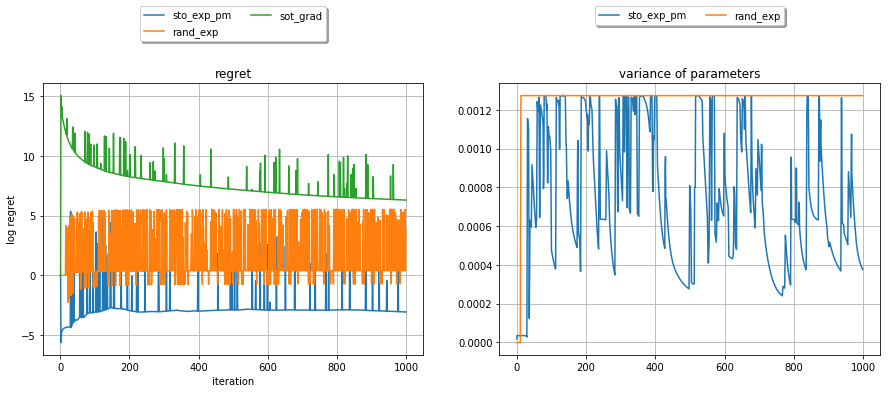

In [252]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15, 5))  # 1 row, 2 columns


ax[0].plot(np.log(param_pm[:,-1]),label='sto_exp_pm')
ax[0].plot(np.log(param_rand[:,-1]),label='rand_exp')
ax[0].plot(np.log(sto_grad[:,-1]),label='sot_grad')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("log regret")
ax[0].set_title("regret")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[1].plot([np.var([param_pm[i,:-1],param_pm[i+1,:-1]]) for i in range(999)],label='sto_exp_pm')
ax[1].plot([np.var([param_rand[i,:-1],param_rand[i+1,:-1]]) for i in range(999)],label='rand_exp')
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)
ax[1].grid()
ax[1].set_title("variance of parameters");

La première chose qu'on remarque c'est que randomized exponential n'est en general que du bruit et que le stochastic exponential plus-minus à l'air de se demarquer des deux autres.

Text(0.5,1,'difference pm vs rand')

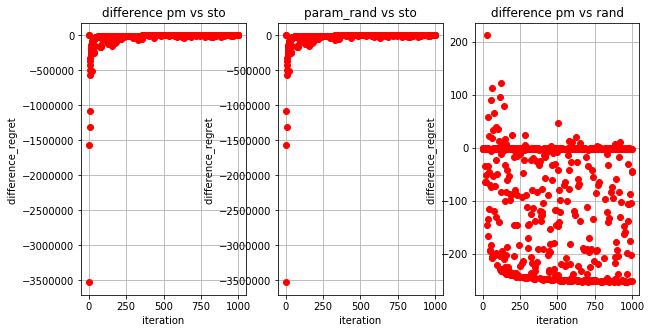

In [254]:
fig,ax = plt.subplots(1,3,figsize=(10,5))
ax[0].plot(param_pm[:,-1]-sto_grad[:,-1],'ro')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("difference_regret ")
ax[0].set_title("difference pm vs sto")
#ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[1].plot(param_rand[:,-1]-sto_grad[:,-1],'ro')
ax[1].grid()
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("difference_regret ")
ax[1].set_title("param_rand vs sto")
#ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[2].plot(param_pm[:,-1]-param_rand[:,-1],'ro')
ax[2].grid()
ax[2].set_xlabel("iteration")
ax[2].set_ylabel("difference_regret ")
ax[2].set_title("difference pm vs rand")
#ax[2].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

Dans l'ensemble, les trois algos sont assez différents.

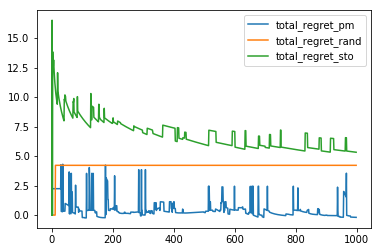

In [256]:
#general diff
plt.plot(np.log(real_regret_pm),label='total_regret_pm')
plt.plot(np.log(real_regret_rand),label='total_regret_rand')
plt.plot(np.log(real_regret_sto),label='total_regret_sto')
plt.legend()

Cette figure confirme bien nos précédentes observations, on peut remarquer que stochastic exponential gradient est très performant par rapport aux autres.

## Adagrad vs Ons vs SGD

In [320]:
def ada_proj(a,b,init,iters,cost,grad,lam,z=1):
    d = len(init)
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    s = d*[1/(4*d*z)]
    eta = 2*z
    
    for i in tqdm.tqdm(range(0,iters)):
        x = param[i,:-1]
        s = s + (gradient(x,a[i,:],b[i],lam)+x)*(gradient(x,a[i,:],b[i],lam)+x)
        y = x - eta * 1/np.sqrt(s)*(gradient(x,a[i,:],b[i],lam)+x)
        param[i+1,:-1] = proj_w(y,np.sqrt(s),z)
        #param[i+1,:-1] = y
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param

In [151]:
def ons_proj(a,b,init,iters,cost,grad,lam,z=1):
    d = len(init)
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    gamm = 1/2*min(1/(8*z),1)
    s = d*[1/(gamm**2 * (2*z)**2)]
    
    for i in tqdm.tqdm(range(0,iters)):
        x = param[i,:-1]
        s = s + (gradient(x,a[i,:],b[i],lam)+x)*(gradient(x,a[i,:],b[i],lam)+x)
        y = x - (1/gamm) * (1/s) *(gradient(x,a[i,:],b[i],lam)+x)
        param[i+1,:-1] = proj_w(y,s,z)
        #param[i+1,:-1] = y
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param

In [212]:
rdm.seed(1)
param_ada = ada_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,10)
rdm.seed(1)
param_ons = ons_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,0.1)
real_regret_ada = [total_cost(param_ada[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

real_regret_ons = [total_cost(param_ons[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

100%|██████████| 1000/1000 [00:00<00:00, 1432.35it/s]


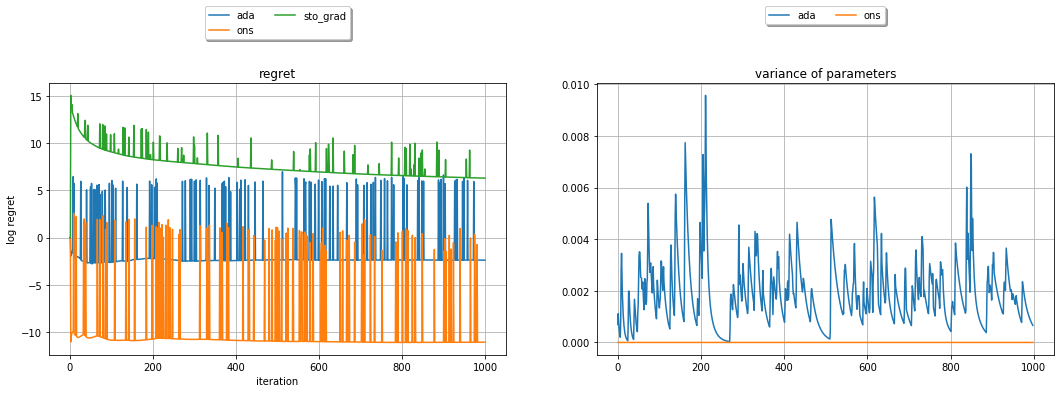

In [267]:



fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18, 5))  # 1 row, 2 columns


ax[0].plot(np.log(param_ada[:,-1]),label='ada')
ax[0].plot(np.log(param_ons[:,-1]),label='ons')
ax[0].plot(np.log(sto_grad[:,-1]),label='sto_grad')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("log regret")
ax[0].set_title("regret")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[1].plot([np.var([param_ada[i,:-1],param_ada[i+1,:-1]]) for i in range(999)],label='ada')
ax[1].plot([np.var([param_ons[i,:-1],param_ons[i+1,:-1]]) for i in range(999)],label='ons')
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)
ax[1].grid()
ax[1].set_title("variance of parameters");


Text(0.5,1,'diff pm vs rand')

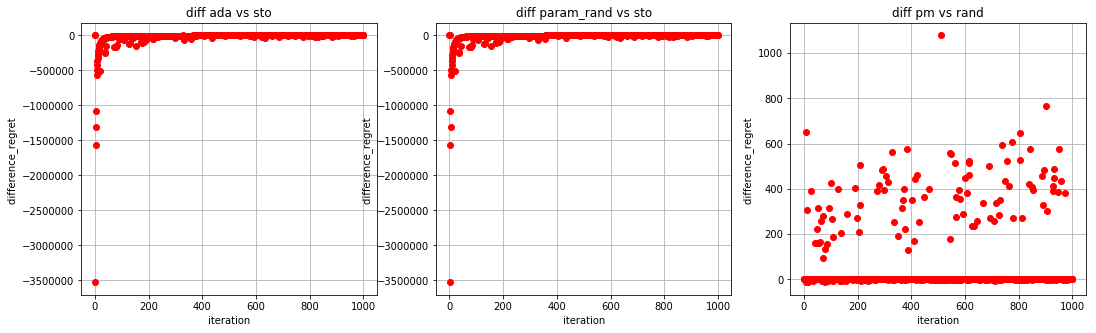

In [268]:

fig,ax = plt.subplots(1,3,figsize=(18, 5))
ax[0].plot(param_ada[:,-1]-sto_grad[:,-1],'ro')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("difference_regret ")
ax[0].set_title("diff ada vs sto")
#ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[1].plot(param_ons[:,-1]-sto_grad[:,-1],'ro')
ax[1].grid()
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("difference_regret ")
ax[1].set_title("diff param_rand vs sto")
#ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[2].plot(param_ada[:,-1]-param_ons[:,-1],'ro')
ax[2].grid()
ax[2].set_xlabel("iteration")
ax[2].set_ylabel("difference_regret ")
ax[2].set_title("diff pm vs rand")
#ax[2].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)



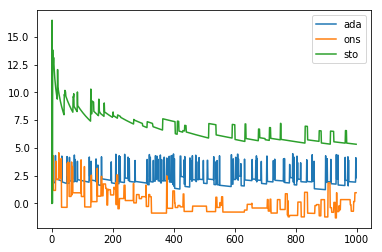

In [270]:
#general diff
plt.plot(np.log(real_regret_ada),label='ada')
plt.plot(np.log(real_regret_ons),label='ons')
plt.plot(np.log(real_regret_sto),label='sto')
plt.legend()

En faisant la meme, on tire la meme conclusion que précédemment. En général, les trois algos sont différents et **Ons** se demarque des autres.

# Benchmark avec 1000 itération (sans tuning)

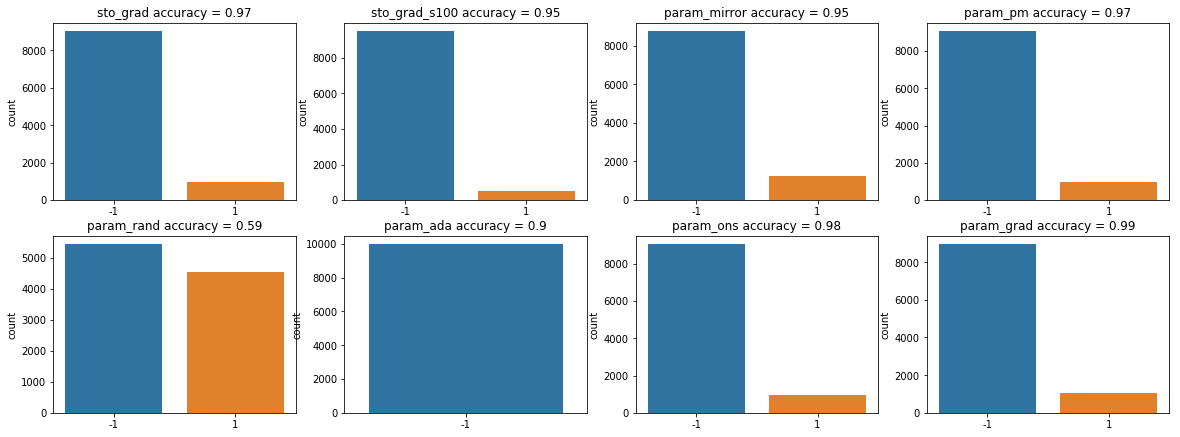

In [291]:

algo = [sto_grad,sto_grad_s100,param_mirror,param_pm,param_rand,param_ada,param_ons,param_grad]
name = ['sto_grad','sto_grad_s100','param_mirror','param_pm','param_rand','param_ada','param_ons','param_grad']



plt.figure(figsize=(20, 15))
for it, (na,a) in enumerate(zip(name,algo)):
    plt.subplot(4, 4, it+1)
    pred = svm_fit(a[-1,:-1],X_test)
    sns.countplot(pred)
    plt.title('{} accuracy = {}'.format(na,round(accuracy_score(pred,Y_test),2)))
    

# Augmentons le nombre d'itération : Benchmark avec 10000 itérations (sans tuning)

In [292]:
rdm.seed(1)
sto_grad2 = sto_grad_descent(X_train,Y_train,np.array(784*[0]),10000,hinge_loss,gradient,1)
rdm.seed(1)
sto_grad_s10002 = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),10000,hinge_loss,gradient,1,100)
rdm.seed(1)
param_mirror2 = sto_mirror_descent(X_train,Y_train,np.array(784*[0]),10000,hinge_loss,gradient,1,1000)
rdm.seed(1)
param_pm2 = sto_exp_grad_mp(X_train,Y_train,10000,hinge_loss,gradient,1,1)
rdm.seed(1)
param_rand2 = rand_exp_grad_mp(X_train,Y_train,10000,hinge_loss,gradient_sca,1,1)
rdm.seed(1)
param_ada2 = ada_proj(X_train,Y_train,np.array(784*[0]),10000,hinge_loss,gradient,1,10)
rdm.seed(1)
param_ons2 = ons_proj(X_train,Y_train,np.array(784*[0]),10000,hinge_loss,gradient,1,0.1)



100%|██████████| 10000/10000 [00:37<00:00, 269.29it/s]


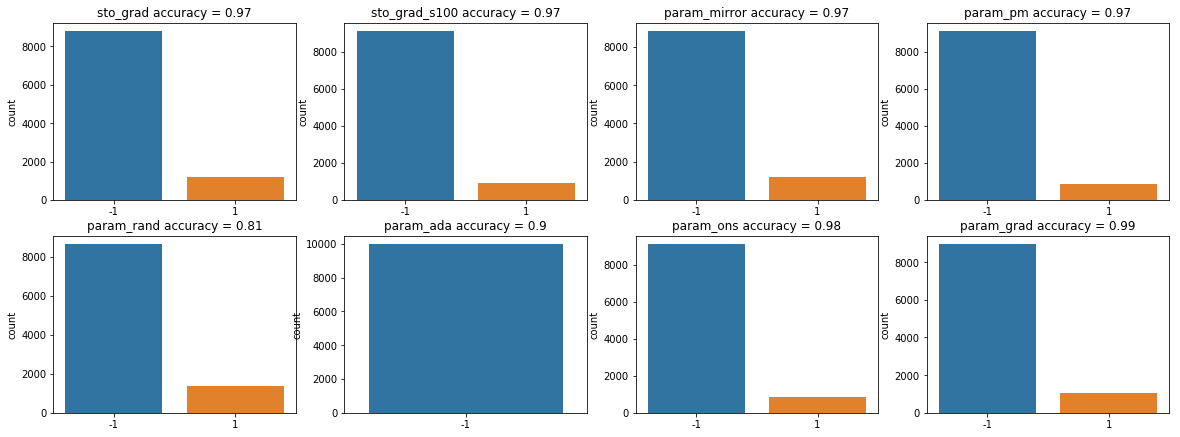

In [293]:

algo = [sto_grad2,sto_grad_s10002,param_mirror2,param_pm2,param_rand2,param_ada2,param_ons2,param_grad]
name = ['sto_grad','sto_grad_s100','param_mirror','param_pm','param_rand','param_ada','param_ons','param_grad']



plt.figure(figsize=(20, 15))
for it, (na,a) in enumerate(zip(name,algo)):
    plt.subplot(4, 4, it+1)
    pred = svm_fit(a[-1,:-1],X_test)
    sns.countplot(pred)
    plt.title('{} accuracy = {}'.format(na,round(accuracy_score(pred,Y_test),2)))
    

# Banditron

In [301]:
import datetime
import random


CATEGORY_MAPPING = ['1', '2', '3', '4', '5', '6', '7', '8', '9','10']

In [302]:
class Perceptron:

    def __init__(self):
        self.dict_length = 784
        self.weights = self.init_weights()
        self.error_rate = 0.0
        self.correct_classified = 0.0
        self.incorrect_classified = 0.0
        self.number_of_rounds = 0.0

    def init_weights(self):
        weights = []
        for i in range(0,len(CATEGORY_MAPPING)):
            weights.append([0.0] * self.dict_length)
        return weights

    def update_weights(self, update_matrix):
        for i in range(0,len(self.weights)):
            for j in range(0,len(self.weights[i])):
                self.weights[i][j] += update_matrix[i][j]

    def get_update_matrix(self, feature_vectors, calculated_label,true_label):
        update_matrix = self.init_weights()
        for i in range(0,len(update_matrix)):
            left = 0.0
            right = 0.0
            if true_label == i:
                left = 1
            if calculated_label == i:
                right = 1.0
            for j in range(0,len(feature_vectors)):
                update_matrix[i][j] = feature_vectors[j] * (left - right)
        return update_matrix

    def run(self, feature_vectors, true_label):
        self.number_of_rounds += 1.0
        calculated_label = self.predict_label(feature_vectors)

        if true_label == calculated_label:
            self.correct_classified += 1.0
        else:
            self.incorrect_classified += 1.0
        self.error_rate = self.incorrect_classified/self.number_of_rounds
       
        update_matrix = self.get_update_matrix(feature_vectors, calculated_label,true_label)
        self.update_weights(update_matrix)

    def predict_label(self, feature_vectors):
        max = 0.0
        label = 0
        for i in range(0,len(self.weights)):
            total = 0.0
            for eachVector in range(0,len(feature_vectors)):
                total += feature_vectors[eachVector]*self.weights[i][eachVector]
            if total >= max:
                max = total
                label = i
        return label



In [303]:
class Banditron:

    def __init__(self):
        self.gamma = 0.2
        self.dict_length = 784
        self.weights = self.init_weights()
        self.error_rate = 0.0
        self.correct_classified = 0.0
        self.incorrect_classified = 0.0
        self.number_of_rounds = 0.0

    def init_weights(self):
        weights = []
        for i in range(0,len(CATEGORY_MAPPING)):
            weights.append([0.0] * self.dict_length)
        return weights

    def update_weights(self, update_matrix):
        for i in range(0,len(self.weights)):
            for j in range(0,len(self.weights[i])):
                self.weights[i][j] += update_matrix[i][j]

    def get_update_matrix(self, feature_vectors, calculated_label, predicted_label, true_label, probabilities):
        update_matrix = self.init_weights()
        for i in range(0,len(update_matrix)):
            left = 0.0
            right = 0.0
            if true_label == predicted_label and predicted_label == i:
                left = 1/probabilities[i]
            if calculated_label == i:
                right = 1.0
            for j in range(0,len(feature_vectors)):
                update_matrix[i][j] = feature_vectors[j] * (left - right)
        return update_matrix

    def run(self, feature_vectors, true_label):
        self.number_of_rounds += 1.0
        calculated_label = self.predict_label(feature_vectors)
        probabilities = self.calc_probabilities(calculated_label)
        predicted_label = self.random_sample(probabilities)
        if true_label == predicted_label:
            self.correct_classified += 1.0
        else:
            self.incorrect_classified += 1.0
        self.error_rate = self.incorrect_classified/self.number_of_rounds
       
        update_matrix = self.get_update_matrix(feature_vectors, calculated_label, predicted_label, true_label, probabilities)
        self.update_weights(update_matrix)

    def predict_label(self, feature_vectors):
        max = 0.0
        label = 0
        for i in range(0,len(self.weights)):
            total = 0.0
            for eachVector in range(0,len(feature_vectors)):
                total += feature_vectors[eachVector]*self.weights[i][eachVector]
            if total >= max:
                max = total
                label = i
        return label

    def calc_probabilities(self, calculated_label):
        probabilities = [0] * len(self.weights)
        for i in range(0,len(probabilities)):
            probabilities[i] = self.gamma/len(self.weights)
            if i == calculated_label:
                probabilities[i] += (1 - self.gamma)
        return probabilities

    def random_sample(self, probabilities):
        number = random.random() * sum(probabilities)
        for i in range(0,len(probabilities)):
            if number < probabilities[i]:
                return i
                break
            number -= probabilities[i]
        return len(probabilities)-1


In [304]:
def main():
    banditron = Banditron()
    percp = Perceptron()
    error_list = list()
    rounds = list()
    error_list_p = list()
    rounds_p = list()
    for i in tqdm.tqdm(range(X_train.shape[0])):
        feature_vector = X_train[i,:]
        #feature_vector =  euclidean_proj_simplex(feature_vector)
        true_label = Y_train[i]
        banditron.run(feature_vector, true_label-1)
        percp.run(feature_vector, true_label-1)
        if ((i+1)%5) == 0:
                rounds.append(banditron.number_of_rounds)
                error_list.append(banditron.error_rate)
                rounds_p.append(percp.number_of_rounds)
                error_list_p.append(percp.error_rate)
                
 
    print ("banditron.correct_classified = ", banditron.correct_classified)
    print ("banditron.incorrect_classified = ", banditron.incorrect_classified)
    print ("banditron.error_rate = ", banditron.error_rate) 
    print ("Perceptron.correct_classified = ", percp.correct_classified)
    print ("Perceptron.incorrect_classified = ", percp.incorrect_classified)
    print ("Perceptron.error_rate = ", percp.error_rate) 
    return rounds,error_list,rounds_p,error_list_p
    

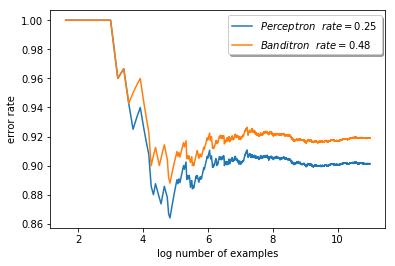

In [307]:
#r,l,r_p,l_p = main()
plt.plot(np.log(r_p), l_p,label='$Perceptron\  \ rate = 0.25$')
plt.plot(np.log(r),l,label='$Banditron\  \ rate = 0.48$')
plt.ylabel('error rate')
plt.xlabel('log number of examples')
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 1), shadow=True, ncol=1)
plt.savefig('banditron')
plt.show()

In [319]:
"""Pour les algorithmes de Thompson sampling, voir dossier TS"""

'Pour les algorithmes de Thompson sampling, voir dossier TS'